In [1]:
import pandas as pd
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.model_selection import cross_validate

import xgboost

from collections import Counter

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")
SEED: int = 42

# Load Data
We load the already processed data from the `data/processed` directory

In [2]:
train_data = pd.read_csv("../../data/processed/train_data_cleaned.csv", index_col="building_id")
y_train = pd.read_csv("../../data/processed/train_labels.csv", index_col="building_id", usecols=["building_id", "damage_grade"])

In [3]:
encoder = LabelEncoder()
train_labels = encoder.fit_transform(y_train["damage_grade"].to_numpy())

In [4]:
print('Original counts of labels %s' % Counter(train_labels))

Original counts of labels Counter({1: 148259, 2: 87218, 0: 25124})


In [5]:
model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

scoring = make_scorer(matthews_corrcoef)

In [6]:
%%time

cv_results = cross_validate(model, train_data, train_labels, cv=5,
                            scoring=scoring,
                            n_jobs=-1,
                            return_train_score=True)

CPU times: user 160 ms, sys: 186 ms, total: 346 ms
Wall time: 12min 28s


In [7]:
print(f"CV Test: {round(np.mean(cv_results['test_score']), 4)} +/- {round(np.std(cv_results['test_score']), 4)} MCC")

CV Test: 0.5125 +/- 0.0047 MCC


# Random Undersampling

In [8]:
model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

In [9]:
from imblearn.under_sampling import RandomUnderSampler

In [10]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(train_data, train_labels)
print('Resampled dataset shape %s' % Counter(y_rus))

Resampled dataset shape Counter({0: 25124, 1: 25124, 2: 25124})


In [11]:
%%time

cv_results_rus = cross_validate(model, X_rus, y_rus, cv=5,
                                scoring=scoring,  #"accuracy",
                                n_jobs=-1,
                                return_train_score=True,
                                verbose=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min


CPU times: user 134 ms, sys: 226 ms, total: 360 ms
Wall time: 2min 33s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


In [12]:
print(f"CV Test: {round(np.mean(cv_results_rus['test_score']), 4)} +/- {round(np.std(cv_results_rus['test_score']), 4)} MCC")

CV Test: 0.5765 +/- 0.0016 MCC


# Random Oversampling

In [13]:
model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

In [14]:
from imblearn.over_sampling import RandomOverSampler

In [15]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(train_data, train_labels)
print('Resampled dataset shape %s' % Counter(y_ros))

Resampled dataset shape Counter({2: 148259, 1: 148259, 0: 148259})


In [16]:
%%time

cv_results_ros = cross_validate(model, X_ros, y_ros, cv=5,
                                scoring=scoring,
                                n_jobs=-1,
                                return_train_score=True, 
                                verbose=0)

CPU times: user 254 ms, sys: 245 ms, total: 499 ms
Wall time: 29min 57s


In [17]:
print(f"CV Test: {round(np.mean(cv_results_ros['test_score']), 4)} +/- {round(np.std(cv_results_ros['test_score']), 4)} MCC")

CV Test: 0.8056 +/- 0.029 MCC


# Combinations of over- and undersampling

## SMOTEENN

In [18]:
model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

In [19]:
from imblearn.combine import SMOTEENN

In [20]:
%%time

sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(train_data, train_labels)

CPU times: user 1h 15min 44s, sys: 205 ms, total: 1h 15min 44s
Wall time: 11min 11s


In [21]:
print('Resampled dataset shape %s' % Counter(y_sme))

Resampled dataset shape Counter({0: 125951, 2: 82828, 1: 50540})


In [22]:
%%time

cv_results_sme = cross_validate(model, X_sme, y_sme, cv=5,
                                scoring=scoring,
                                n_jobs=-1,
                                return_train_score=True, 
                                verbose=0)

CPU times: user 220 ms, sys: 280 ms, total: 500 ms
Wall time: 16min 57s


In [23]:
print(f"CV Test: {round(np.mean(cv_results_sme['test_score']), 4)} +/- {round(np.std(cv_results_sme['test_score']), 4)} MCC")

CV Test: 0.9066 +/- 0.0542 MCC


## SMOTETomek

In [24]:
model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

In [25]:
from imblearn.combine import SMOTETomek

In [26]:
%%time

tom = SMOTETomek(random_state=42)
X_tom, y_tom = tom.fit_resample(train_data, train_labels)

CPU times: user 1h 15min 31s, sys: 1.1 s, total: 1h 15min 32s
Wall time: 11min 8s


In [27]:
print('Resampled dataset shape %s' % Counter(y_sme))

Resampled dataset shape Counter({0: 125951, 2: 82828, 1: 50540})


In [28]:
%%time

cv_results_tom = cross_validate(model, X_tom, y_tom, cv=5,
                                scoring=scoring,
                                n_jobs=-1,
                                return_train_score=True, 
                                verbose=0)

CPU times: user 358 ms, sys: 236 ms, total: 594 ms
Wall time: 31min 52s


In [29]:
print(f"CV Test: {round(np.mean(cv_results_tom['test_score']), 4)} +/- {round(np.std(cv_results_tom['test_score']), 4)} MCC")

CV Test: 0.7485 +/- 0.1222 MCC


# Same methods but with train, test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [ ]:
model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = matthews_corrcoef(y_test, predictions)

print(f"MCC: {round(score, 4)}")

In [ ]:
%%time

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_rus))

model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

model.fit(X_rus, y_rus)
predictions = model.predict(X_test)
score = matthews_corrcoef(y_test, predictions)

print(f"MCC: {round(score, 4)}")

In [ ]:
%%time 

# Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_ros))

model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

model.fit(X_ros, y_ros)
predictions = model.predict(X_test)
score = matthews_corrcoef(y_test, predictions)

print(f"MCC: {round(score, 4)}")

In [ ]:
%%time 

# SMOTEENN
sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_sme))

model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

model.fit(X_sme, y_sme)
predictions = model.predict(X_test)
score = matthews_corrcoef(y_test, predictions)

print(f"MCC: {round(score, 4)}")

In [ ]:
%%time

# SMOTETomek
tom = SMOTETomek(random_state=42)
X_tom, y_tom = tom.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_tom))

model = xgboost.XGBClassifier(n_estimators=100,
                              max_depth=20,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42,
                              n_jobs=-1)

model.fit(X_tom, y_tom)
predictions = model.predict(X_test)
score = matthews_corrcoef(y_test, predictions)

print(f"MCC: {round(score, 4)}")

# Plot the results

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

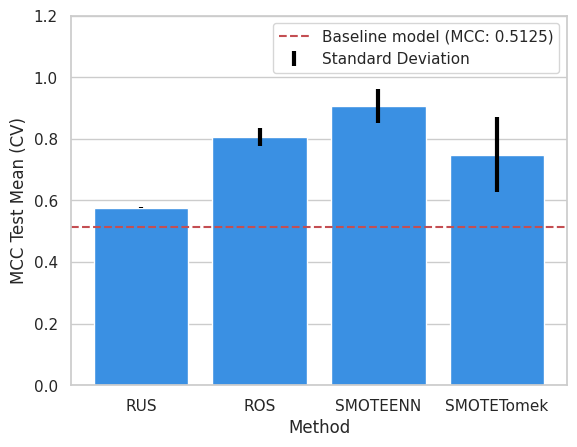

In [21]:
# CV
# Take the results from above and plot them
baseline = 0.5125  # XGBoost

data = {
    "Method"            : ["RUS", "ROS", "SMOTEENN", "SMOTETomek"],
    "MCC Test Mean (CV)": [0.5765, 0.8056, 0.9066, 0.7485],
    "SD"                : [0.0016, 0.0290, 0.0542, 0.1222]
}

plot_df = pd.DataFrame(data=data)

ax = sns.barplot(data=plot_df, x='Method', y='MCC Test Mean (CV)', color='dodgerblue')
ax.errorbar(data=plot_df, x='Method', y='MCC Test Mean (CV)', yerr='SD', ls='', lw=3, color='black', label="Standard Deviation")
ax.axhline(baseline, color='r', ls='--', label='Baseline model (MCC: 0.5125)')
ax.set_ylim([0.0, 1.2])
plt.legend()
plt.show()

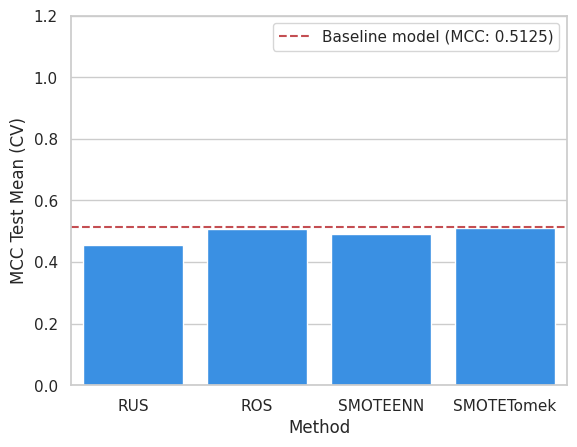

In [22]:
# Hold out
# Take the results from above and plot them
baseline = 0.5125  # XGBoost

data = {
    "Method"            : ["RUS", "ROS", "SMOTEENN", "SMOTETomek"],
    "MCC Test Mean (CV)": [0.4546, 0.5069, 0.4911, 0.5121],
    # "SD"                : [0.0016, 0.0290, 0.0542, 0.1222]
}

plot_df = pd.DataFrame(data=data)

ax = sns.barplot(data=plot_df, x='Method', y='MCC Test Mean (CV)', color='dodgerblue')
#ax.errorbar(data=plot_df, x='Method', y='MCC Test Mean (CV)', yerr='SD', ls='', lw=3, color='black', label="Standard Deviation")
ax.axhline(baseline, color='r', ls='--', label='Baseline model (MCC: 0.5125)')
ax.set_ylim([0.0, 1.2])
plt.legend()
plt.show()

# Conclusion

At a first glimpse it looks like those methods improve the results. 
But when performin a CV in this way, the test set is also sampled and does not represent the reality we want to model. 
So I chose to perform the same methods on a hold out set, which is not sampled. 
Here I can see, that the results are (even if only little) worse compared to the training on the original data set.

I also believe that methods using SMOTE are not so suitable for categorical or binary data, because new data points are created using linear combination of the existing data points. 
In this case it means creating new categories respective non-existent states of binary features.